## Build New Dataset

*Based on the feedbacks from the advisor, this will be my new approach to the dataset*

- Pull the data from NYT with the Asian American tags, in sorted order
- If the data is older than 01-21-2020, stop because that's the earliest data from the NYT Covid-19 data
- Dataset include: headline, date, One-hot encoding for 13 tags, news_desk, word_counts, url
- Aggregate by date the dataset

#### Set up the key and use a configparser to hide the key details

In [3]:
# Set up the key
import os
import configparser
# Use a parser for the configuration file
import pandas as pd

configs = configparser.ConfigParser()
# Get the current directory to the main file README.md
currentDir = os.path.dirname("README.md")
# Get the path file to the config file
configDir = os.path.join(currentDir, "config/settings.cfg")
configs.read(configDir)
# Get the key
apiKey = configs.get("nytimes", "api_key")

#### Find total numbers of articles in the topic with the numbers of hits

In [4]:
import requests
subject = "subject:Asian-Americans"
query = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?fq={subject}&sort=newest&api-key={apiKey}'
response = requests.get(query).json()
numHits = response['response']['meta']['hits']

In [5]:
# Method to set up and parse the
import time
import dateutil
import pandas as pd
from datetime import datetime
day = datetime(2020, 1, 21).date()
numPerPages = 10
def isNotValid(article) -> bool:
    """
    Method to check if the article has a valid headline

    :param article: The information of the article
    :return: True if not valid, False if valid
    """
    if type(article['headline']) == dict and 'main' in article['headline'] and article['headline']['main'] is not None:
        return False
    return True

def getDataSorted() -> pd.DataFrame:
    """
    Main method to send request and parse response with the subject

    :return: Dataset with all the articles parsed as panda dataframe
    """
    # Result dataset
    dataset = {'headline': [],
        'date': [],
        'news_desk': [],
        'word_count': [],
        'Hate Crimes': [],
        'Discrimination': [],
        'Race and Ethnicity': [],
        'Atlanta Spa Shootings (2021)': [],
        'Murders, Attempted Murders and Homicides': [],
        'Demonstrations, Protests and Riots': [],
        'Mass Shootings': [],
        'Quarantine (Life and Culture)': [],
        'Assaults': [],
        'Minorities': [],
        'Workplace Hazards and Violations': [],
        'Coronavirus (2019-nCoV)': [],
        'url': []}

    breakCondition = False
    dataset = pd.DataFrame(dataset)
    # Count number of articles
    total = 0
    # Loop through the page
    for page in range(numHits // numPerPages + 1):
        # Send request to the page gradually
        q = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?fq={subject}&page={page}&sort=newest&api-key={apiKey}'
        r = requests.get(q).json()
        # Based on preliminary parsing, get the list of article from the file
        articleList = r['response']['docs']
        # Return dataframe
        frame = getRequestUpdate(articleList, breakCondition)
        # Return
        if len(frame) == 0:
            break
        # Add to dataset
        dataset = dataset.append(frame, ignore_index=True)
        # Count pages
        total += len(frame)
        # Sleep before new request
        time.sleep(6)
        # Print message to know finish with the page
        print("Finish with page", page)
    # Print when done with the numbers of total articles
    print(f'Finished with all pages, total of {str(total)}')
    # Create csv file
    csv_path = "Updated Asians American NYT Dataset.csv"
    dataset.to_csv(csv_path, index=False)
    return dataset

tags = {'Hate Crimes',
        'Discrimination',
        'Race and Ethnicity',
        'Atlanta Spa Shootings (2021)',
        'Murders, Attempted Murders and Homicides',
        'Demonstrations, Protests and Riots',
        'Mass Shootings',
        'Quarantine (Life and Culture)',
        'Assaults',
        'Minorities',
        'Workplace Hazards and Violations',
        'Coronavirus (2019-nCoV)'}

def keywordCheck(frame, keywords, num):
    """
    Method to do one-hot encoding for the keywords

    :param num: The article number on the list
    :param frame: the current dataframe
    :param keywords: the list of keywords
    :return: None
    """
    for keyword in keywords:
        if keyword['name'] != 'subject':
            continue
        # All the keywords are subject
        if keyword['value'] == 'Assaults':
            frame['Assaults'].append(1)
        # minorities
        elif keyword['value'] == 'Minorities':
            frame['Minorities'].append(1)
        # hazards
        elif keyword['value'] == 'Workplace Hazards and Violations':
            frame['Workplace Hazards and Violations'].append(1)
        # covid 19
        elif keyword['value'] == 'Coronavirus (2019-nCoV)':
            frame['Coronavirus (2019-nCoV)'].append(1)
        # shootings
        elif keyword['value'] =='Mass Shootings' :
            frame['Mass Shootings'].append(1)
        # quarantine
        elif keyword['value'] == 'Quarantine (Life and Culture)' :
            frame['Quarantine (Life and Culture)'].append(1)
        # Discrimination
        elif keyword['value'] == 'Discrimination':
            frame['Discrimination'].append(1)
        # Protest and riot
        elif keyword['value'] == 'Demonstrations, Protests and Riots':
            frame['Demonstrations, Protests and Riots'].append(1)
        # Murders, homicides
        elif keyword['value'] == 'Murders, Attempted Murders and Homicides':
            frame['Murders, Attempted Murders and Homicides'].append(1)
        # Race and ethnicity
        elif keyword['value'] == 'Race and Ethnicity':
            frame['Race and Ethnicity'].append(1)
        # Atlanta
        elif keyword['value'] == 'Atlanta Spa Shootings (2021)':
            frame['Atlanta Spa Shootings (2021)'].append(1)
        # Discrimination
        elif keyword['value'] == 'Hate Crimes':
            frame['Hate Crimes'].append(1)

    for tag in tags:
        # print(frame[tag])
        while len(frame[tag]) < num + 1:
            frame[tag].append(0)


def getRequestUpdate(articleList, breakCondition) -> pd.DataFrame:
    """
    Method to parse article and return as a data frame

    :param breakCondition:
    :param articleList: list of article from response['response']['docs']
    :return: dataframe of the article after parsing
    """
    frame = {'headline': [],
        'date': [],
        'news_desk': [],
        'word_count': [],
        'Hate Crimes': [],
        'Discrimination': [],
        'Race and Ethnicity': [],
        'Atlanta Spa Shootings (2021)': [],
        'Murders, Attempted Murders and Homicides': [],
        'Demonstrations, Protests and Riots': [],
        'Mass Shootings': [],
        'Quarantine (Life and Culture)': [],
        'Assaults': [],
        'Minorities': [],
        'Workplace Hazards and Violations': [],
        'Coronavirus (2019-nCoV)': [],
        'url': []}
    for idx, article in enumerate(articleList):
        # Check if article is valid
        if isNotValid(article):
            continue
        # Date parse
        date = dateutil.parser.parse(article['pub_date']).date()
        # Return when the date is larger
        if date < day:
            break
        frame['date'].append(str(date))
        # Headline parse
        frame['headline'].append(article['headline']['main'])
        # Link URL parse
        frame['url'].append(article['web_url'])

        # News Desk parse
        if 'news_desk' in article:
            frame['news_desk'].append(article['news_desk'])
        else:
            frame['news_desk'].append(article[None])
        # Word count parse
        if 'word_count' in article:
            frame['word_count'].append(article['word_count'])
        else:
            frame['word_count'].append(article[None])

        keywordCheck(frame, article['keywords'], idx)

    return pd.DataFrame(frame)

updatedData = getDataSorted()
updatedData.head(10)

Finish with page 0
Finish with page 1
Finish with page 2
Finish with page 3
Finish with page 4
Finish with page 5
Finish with page 6
Finish with page 7
Finish with page 8
Finish with page 9
Finish with page 10
Finish with page 11
Finish with page 12
Finish with page 13
Finish with page 14
Finish with page 15
Finish with page 16
Finish with page 17
Finish with page 18
Finish with page 19
Finish with page 20
Finished with all pages, total of 210


headline        date  \
0              Critical Race Theory: A Brief History  2021-07-27   
1  Asians Are Represented in Classical Music. But...  2021-07-21   
2      A Violinist on How to Empower Asian Musicians  2021-07-21   
3  A Rising Star’s Career Was Cut Short. His Impa...  2021-07-19   
4  Fear, and Discord, Among Asian Americans Over ...  2021-07-18   
5  Boston Overhauls Admissions to Exclusive Exam ...  2021-07-15   
6  A ‘Rogue Ballerina’ Gives a Candid Account of ...  2021-07-14   
7        Anti-Asian Attacks Continue as City Reopens  2021-07-14   
8  ‘No Vaccine for Racism’: Asian New Yorkers Sti...  2021-07-14   
9  Shohei Ohtani Is Just the Star America’s Pasti...  2021-07-12   

      news_desk  word_count  Hate Crimes  Discrimination  Race and Ethnicity  \
0       Express      1417.0          0.0             0.0                 1.0   
1  Arts&Leisure      2405.0          0.0             1.0                 1.0   
2  Arts&Leisure      1161.0          0.0             1.0                 1.0   
3       Culture      1516.0          0.0             0.0                 0.0   
4      National      1387.0          1.0             1.0                 0.0   
5      National      1480.0          0.0             0.0                 1.0   
6  Arts&Leisure      1742.0          0.0             0.0                 1.0   
7         Metro      1114.0          1.0             0.0                 0.0   
8         Metro      1348.0          1.0             1.0                 0.0   
9        Sports      1032.0          0.0             1.0                 0.0   

   Atlanta Spa Shootings (2021)  Murders, Attempted Murders and Homicides  \
0                           0.0                                       0.0   
1                           0.0                                       0.0   
2                           0.0                                       0.0   
3                           0.0                                       0.0   
4                           0.0                                       0.0   
5                           0.0                                       0.0   
6                           0.0                                       0.0   
7                           0.0                                       0.0   
8                           0.0                                       0.0   
9                           0.0                                       0.0   

   Demonstrations, Protests and Riots  Mass Shootings  \
0                                 0.0             0.0   
1                                 0.0             0.0   
2                                 0.0             0.0   
3                                 0.0             0.0   
4                                 0.0             0.0   
5                                 0.0             0.0   
6                                 0.0             0.0   
7                                 0.0             0.0   
8                                 0.0             0.0   
9                                 0.0             0.0   

   Quarantine (Life and Culture)  Assaults  Minorities  \
0                            0.0       0.0         0.0   
1                            0.0       0.0         0.0   
2                            0.0       0.0         0.0   
3                            0.0       0.0         0.0   
4                            0.0       1.0         0.0   
5                            0.0       0.0         0.0   
6                            0.0       0.0         0.0   
7                            0.0       0.0         0.0   
8                            0.0       1.0         0.0   
9                            0.0       0.0         0.0   

   Workplace Hazards and Violations  Coronavirus (2019-nCoV)  \
0                               0.0                      0.0   
1                               0.0                      0.0   
2                               0.0                      0.0   
3                               0.0        

neighborhood app like facebook for neighbor, coming from new grad, a great start, not startup, not big company,have a say in the project
helpful people and care about what they work for, know where things are, talk

### Overview of The New Dataset

- Get the sum of the tag in this period starting from Jan, 21st, 2020 to Jul, 21st, 2021

In [6]:
updatedData.drop(["headline", "news_desk", "url"], axis=1).agg("sum", axis=0)

date                                        2021-07-272021-07-212021-07-212021-07-192021-0...
word_count                                                                           222582.0
Hate Crimes                                                                              67.0
Discrimination                                                                          107.0
Race and Ethnicity                                                                       76.0
Atlanta Spa Shootings (2021)                                                             42.0
Murders, Attempted Murders and Homicides                                                 22.0
Demonstrations, Protests and Riots                                                        5.0
Mass Shootings                                                                            3.0
Quarantine (Life and Culture)                                                             7.0
Assaults                                                    

- Count value in the news_desk to see the categories that has the most values

In [7]:
updatedData.loc[::, ["news_desk"]].value_counts()

# Based on the count, we can see around 10 articles are not in any news_desk. Note that one article is only tagged with one news_desk
# National and U.S. news desk - What's the difference?

news_desk     
National          31
OpEd              23
Culture           22
Metro             22
Express           15
Washington        10
                  10
Arts&Leisure       9
Politics           6
Sports             6
Letters            5
Business           5
Styles             4
Podcasts           4
SundayBusiness     4
U.S.               3
Well               3
Metropolitan       3
Magazine           3
Weekend            2
Obits              2
Investigative      2
Dining             2
Editorial          2
TStyle             1
T Magazine         1
Summary            1
Climate            1
Science            1
Parenting          1
Business Day       1
AtHome             1
Arts               1
NYTNow             1
BookReview         1
Opinion            1
dtype: int64

- Average and max word counts for the articles
- Divide the articles by tag?

In [8]:
updatedData["word_count"].max()

3156.0

In [9]:
updatedData.loc[updatedData["word_count"].idxmax()]

headline                                                               Did I Just Get Yanged?
date                                                                               2020-01-31
news_desk                                                                                OpEd
word_count                                                                             3156.0
Hate Crimes                                                                               0.0
Discrimination                                                                            0.0
Race and Ethnicity                                                                        0.0
Atlanta Spa Shootings (2021)                                                              0.0
Murders, Attempted Murders and Homicides                                                  0.0
Demonstrations, Protests and Riots                                                        0.0
Mass Shootings                                              

In [10]:
updatedData["word_count"].mean()

1059.9142857142858

- Numbers of articles that have at least 1 tag on them

In [11]:
zeroData = updatedData.iloc[::, range(4, 16)]
zeroList = zeroData.any(axis='columns')
zeroList

0       True
1       True
2       True
3      False
4       True
       ...  
205    False
206     True
207    False
208    False
209    False
Length: 210, dtype: bool

In [12]:
zeroList.value_counts()
# 42 articles do not have any tags we mentioned

True     168
False     42
dtype: int64

- Group by date and delete the word_count

In [13]:
dateData = updatedData.groupby(["date"]).sum().drop("word_count", axis=1)
dateData

Hate Crimes  Discrimination  Race and Ethnicity  \
date                                                          
2020-01-25          0.0             0.0                 0.0   
2020-01-30          0.0             0.0                 0.0   
2020-01-31          0.0             0.0                 0.0   
2020-02-11          0.0             0.0                 0.0   
2020-02-12          0.0             0.0                 0.0   
...                 ...             ...                 ...   
2021-07-15          0.0             0.0                 1.0   
2021-07-18          1.0             1.0                 0.0   
2021-07-19          0.0             0.0                 0.0   
2021-07-21          0.0             2.0                 2.0   
2021-07-27          0.0             0.0                 1.0   

            Atlanta Spa Shootings (2021)  \
date                                       
2020-01-25                           0.0   
2020-01-30                           0.0   
2020-01-31                           0.0   
2020-02-11                           0.0   
2020-02-12                           0.0   
...                                  ...   
2021-07-15                           0.0   
2021-07-18                           0.0   
2021-07-19                           0.0   
2021-07-21                           0.0   
2021-07-27                           0.0   

            Murders, Attempted Murders and Homicides  \
date                                                   
2020-01-25                                       0.0   
2020-01-30                                       0.0   
2020-01-31                                       0.0   
2020-02-11                                       0.0   
2020-02-12                                       0.0   
...                                              ...   
2021-07-15                                       0.0   
2021-07-18                                       0.0   
2021-07-19                                       0.0   
2021-07-21                                       0.0   
2021-07-27                                       0.0   

            Demonstrations, Protests and Riots  Mass Shootings  \
date                                                             
2020-01-25                                 0.0             0.0   
2020-01-30                                 0.0             0.0   
2020-01-31                                 0.0             0.0   
2020-02-11                                 0.0             0.0   
2020-02-12                                 0.0             0.0   
...                                        ...             ...   
2021-07-15                                 0.0             0.0   
2021-07-18                                 0.0             0.0   
2021-07-19                                 0.0             0.0   
2021-07-21                                 0.0             0.0   
2021-07-27                                 0.0             0.0   

            Quarantine (Life and Culture)  Assaults  Minorities  \
date                                                              
2020-01-25                            0.0       0.0         0.0   
2020-01-30                            0.0       0.0         0.0   
2020-01-31                            0.0       0.0         0.0   
2020-02-11                            0.0       0.0         1.0   
2020-02-12                            0.0       0.0         0.0   
...                                   ...       ...         ...   
2021-07-15                            0.0       0.0         0.0   
2021-07-18                            0.0       1.0         0.0   
2021-07-19                            0.0       0.0         0.0   
2021-07-21                            0.0       0.0         0.0   
2021-07-27                            0.0       0.0         0.0   

            Workplace Hazards and Violations  Coronavirus (2019-nCoV)  
date                                                                   
2020-01-25     

### Update the date aggregrated data with the US Covid Cases

In [14]:
covidData = pd.read_csv("us.csv")
covidData

date     cases  deaths
0    2020-01-21         1       0
1    2020-01-22         1       0
2    2020-01-23         1       0
3    2020-01-24         2       0
4    2020-01-25         3       0
..          ...       ...     ...
547  2021-07-21  34222629  609508
548  2021-07-22  34286340  609870
549  2021-07-23  34368845  610313
550  2021-07-24  34391317  610414
551  2021-07-25  34405954  610463

[552 rows x 3 columns]

In [15]:
merged = pd.merge(covidData, updatedData, on=["date"])
merged.drop(['headline', 'news_desk', 'url'], axis=1)

date     cases  deaths  word_count  Hate Crimes  Discrimination  \
0    2020-01-25         3       0       927.0          0.0             0.0   
1    2020-01-30         6       0       327.0          0.0             0.0   
2    2020-01-31         7       0      3156.0          0.0             0.0   
3    2020-02-11        13       0      1075.0          0.0             0.0   
4    2020-02-12        14       0      1408.0          0.0             0.0   
..          ...       ...     ...         ...          ...             ...   
204  2021-07-15  33967961  608103      1480.0          0.0             0.0   
205  2021-07-18  34042378  608580      1387.0          1.0             1.0   
206  2021-07-19  34098206  608811      1516.0          0.0             0.0   
207  2021-07-21  34222629  609508      2405.0          0.0             1.0   
208  2021-07-21  34222629  609508      1161.0          0.0             1.0   

     Race and Ethnicity  Atlanta Spa Shootings (2021)  \
0                   0.0                           0.0   
1                   0.0                           0.0   
2                   0.0                           0.0   
3                   0.0                           0.0   
4                   0.0                           0.0   
..                  ...                           ...   
204                 1.0                           0.0   
205                 0.0                           0.0   
206                 0.0                           0.0   
207                 1.0                           0.0   
208                 1.0                           0.0   

     Murders, Attempted Murders and Homicides  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
204                                       0.0   
205                                       0.0   
206                                       0.0   
207                                       0.0   
208                                       0.0   

     Demonstrations, Protests and Riots  Mass Shootings  \
0                                   0.0             0.0   
1                                   0.0             0.0   
2                                   0.0             0.0   
3                                   0.0             0.0   
4                                   0.0             0.0   
..                                  ...             ...   
204                                 0.0             0.0   
205                                 0.0             0.0   
206                                 0.0             0.0   
207                                 0.0             0.0   
208                                 0.0             0.0   

     Quarantine (Life and Culture)  Assaults  Minorities  \
0                              0.0       0.0         0.0   
1                              0.0       0.0         0.0   
2                              0.0       0.0         0.0   
3                              0.0       0.0         1.0   
4                              0.0       0.0         0.0   
..                             ...       ...         ...   
204                            0.0       0.0         0.0   
205                            0.0       1.0         0.0   
206                            0.0       0.0         0.0   
207                            0.0       0.0         0.0   
208                            0.0       0.0         0.0   

     Workplace Hazards and Violations  Coronavirus (2019-nCoV)  
0                                 0.0                      0.0  
1                                 0.0                      0.0  
2                                 0.0                      0.0  
3                                 0.0                      0.0  
4                                 0.0        

## Word Cloud Visualization

### Generate Wordcloud with Headlines from The Pandemic Time

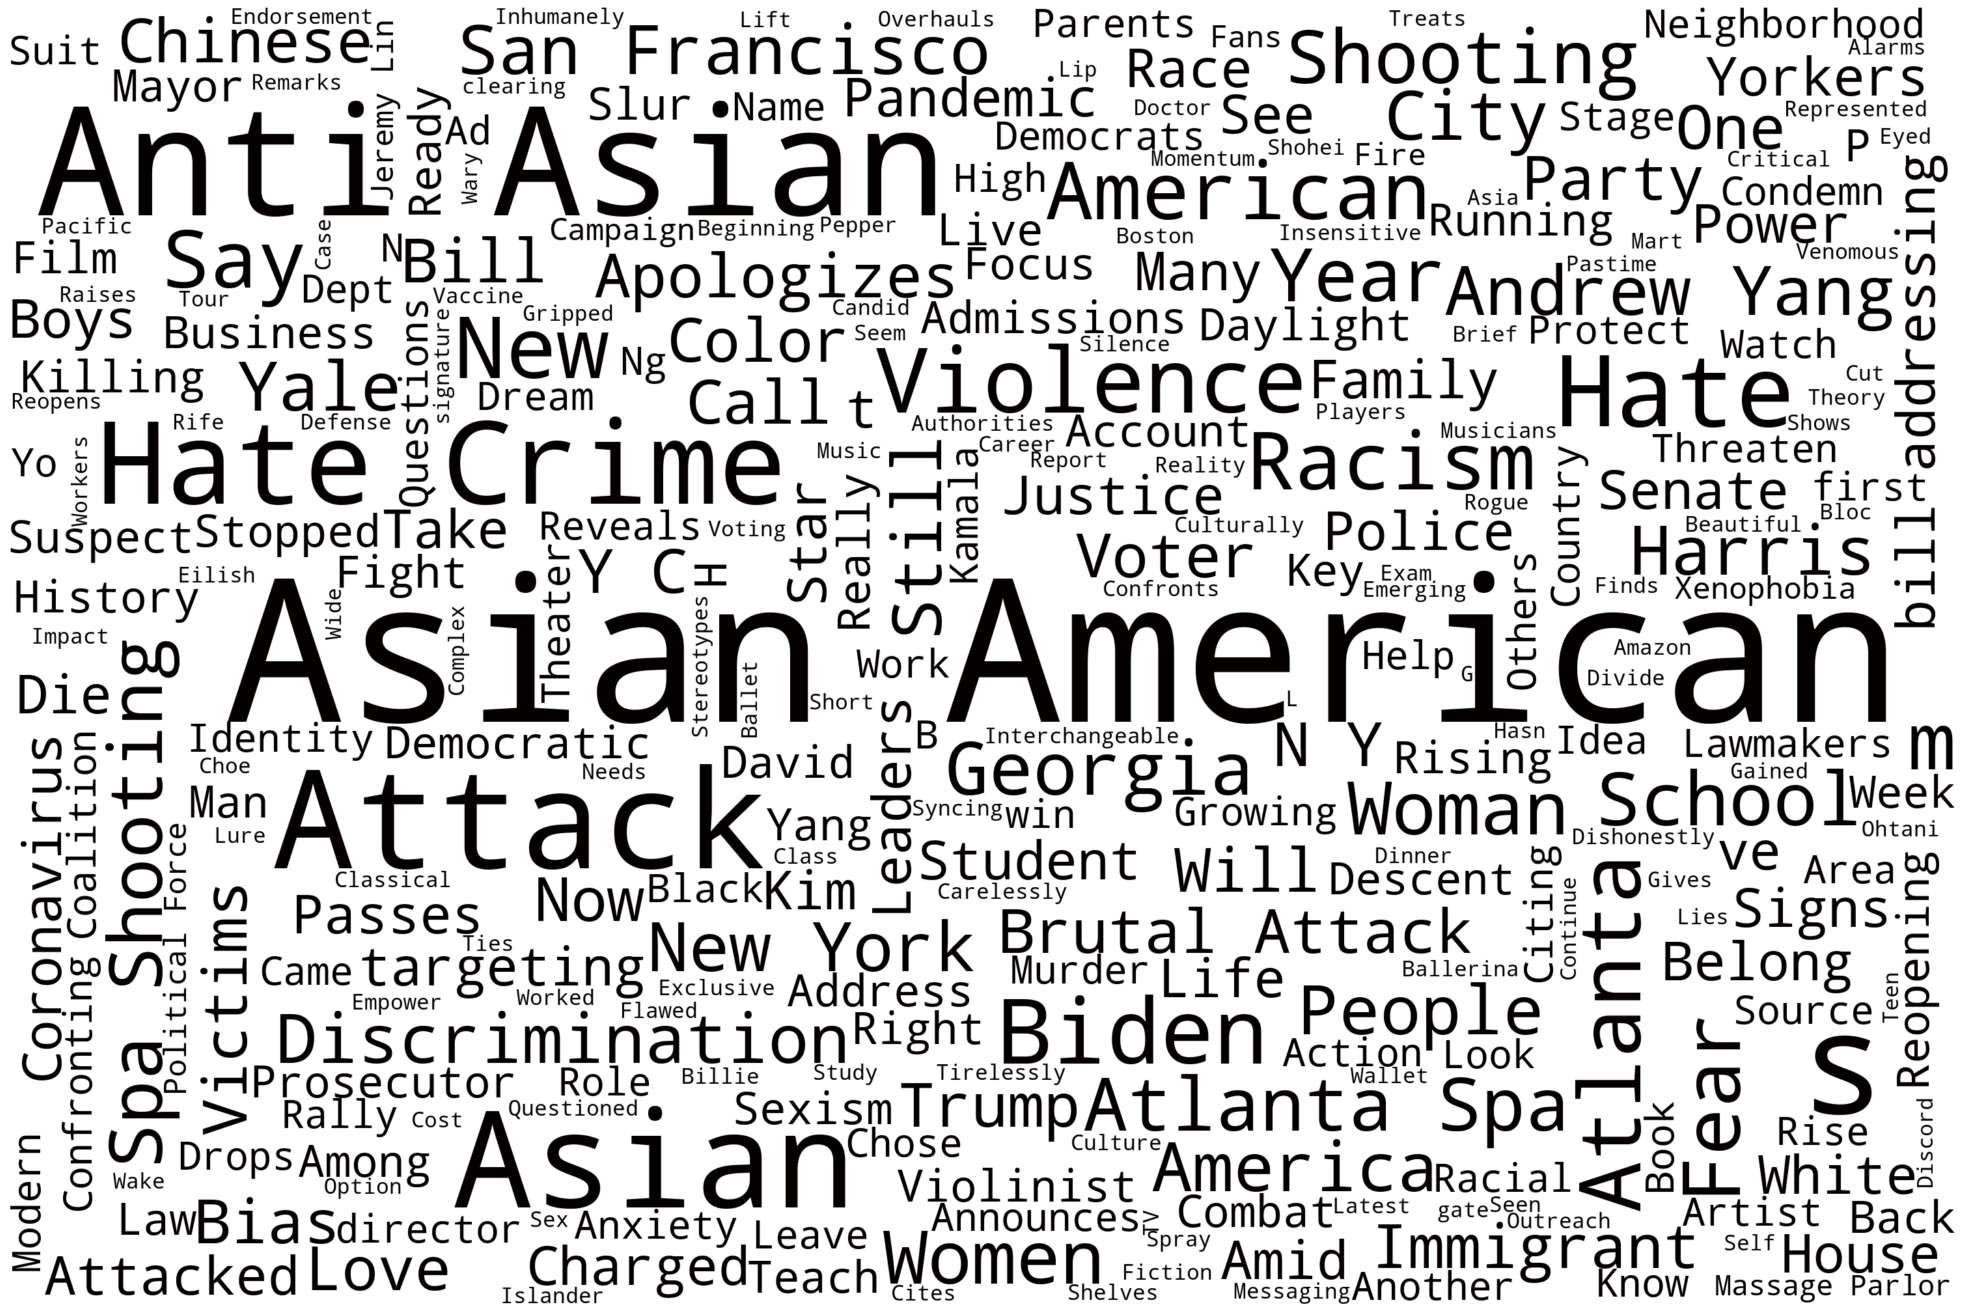

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Imported from the article in https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f
# change the value to black

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    # Function to create color visualizations
    return("hsl(0,100%, 1%)")

headlines = " ".join(" ".join(headline.split(" ")) for headline in updatedData["headline"])
cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=300).generate_from_text(headlines)
cloud.recolor(color_func=black_color_func)

plt.figure(figsize=[35, 30])
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Pandemic Word Cloud.png')
plt.show()

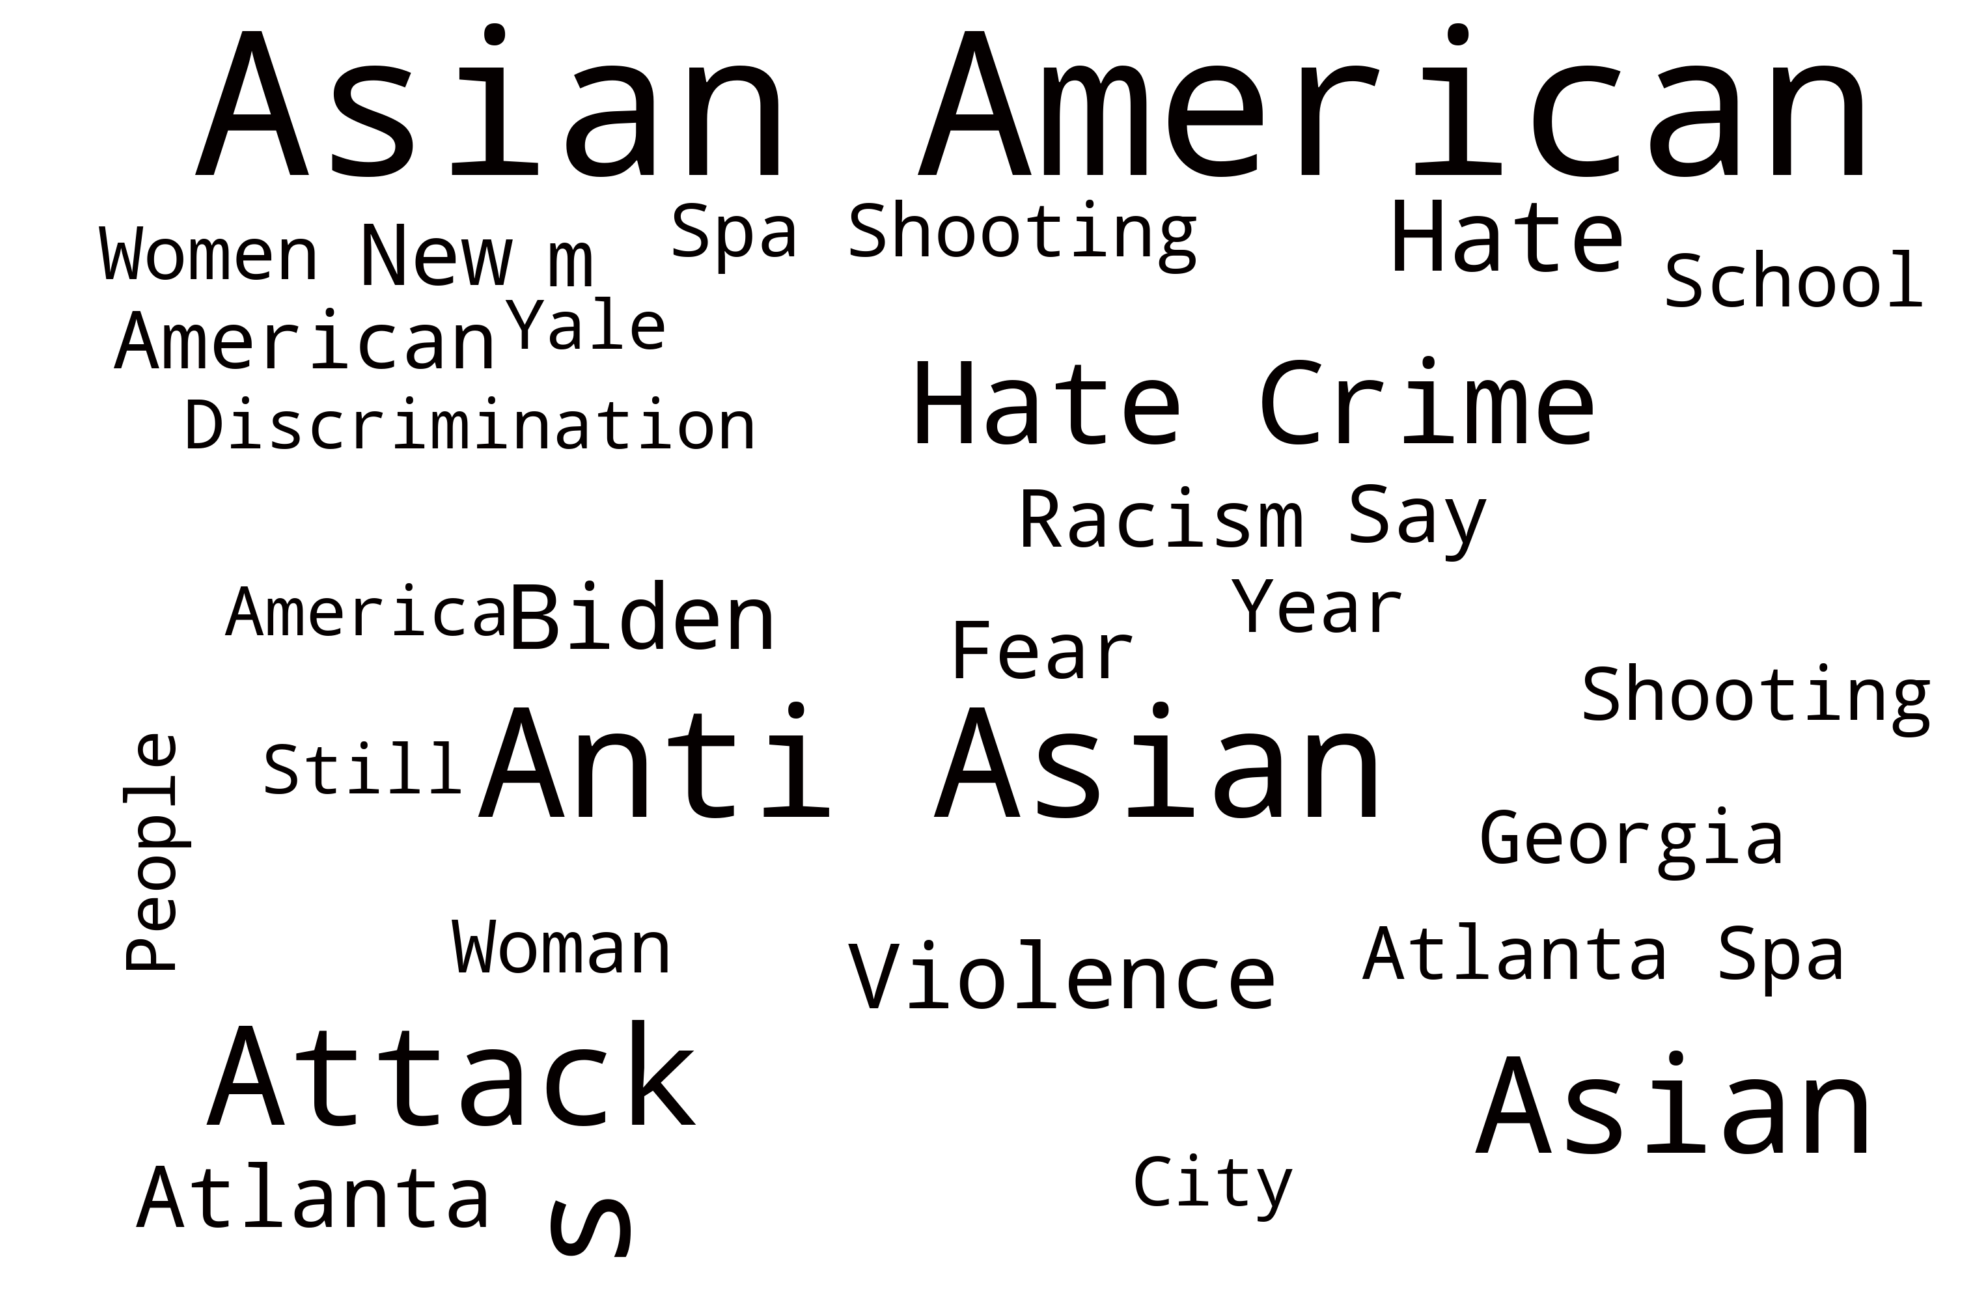

In [30]:
cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=30).generate_from_text(headlines)
cloud.recolor(color_func=black_color_func)

plt.figure(figsize=[35, 30])
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Pandemic Limited Word Cloud.png')
plt.show()

### Generate Wordcloud with All Headlines

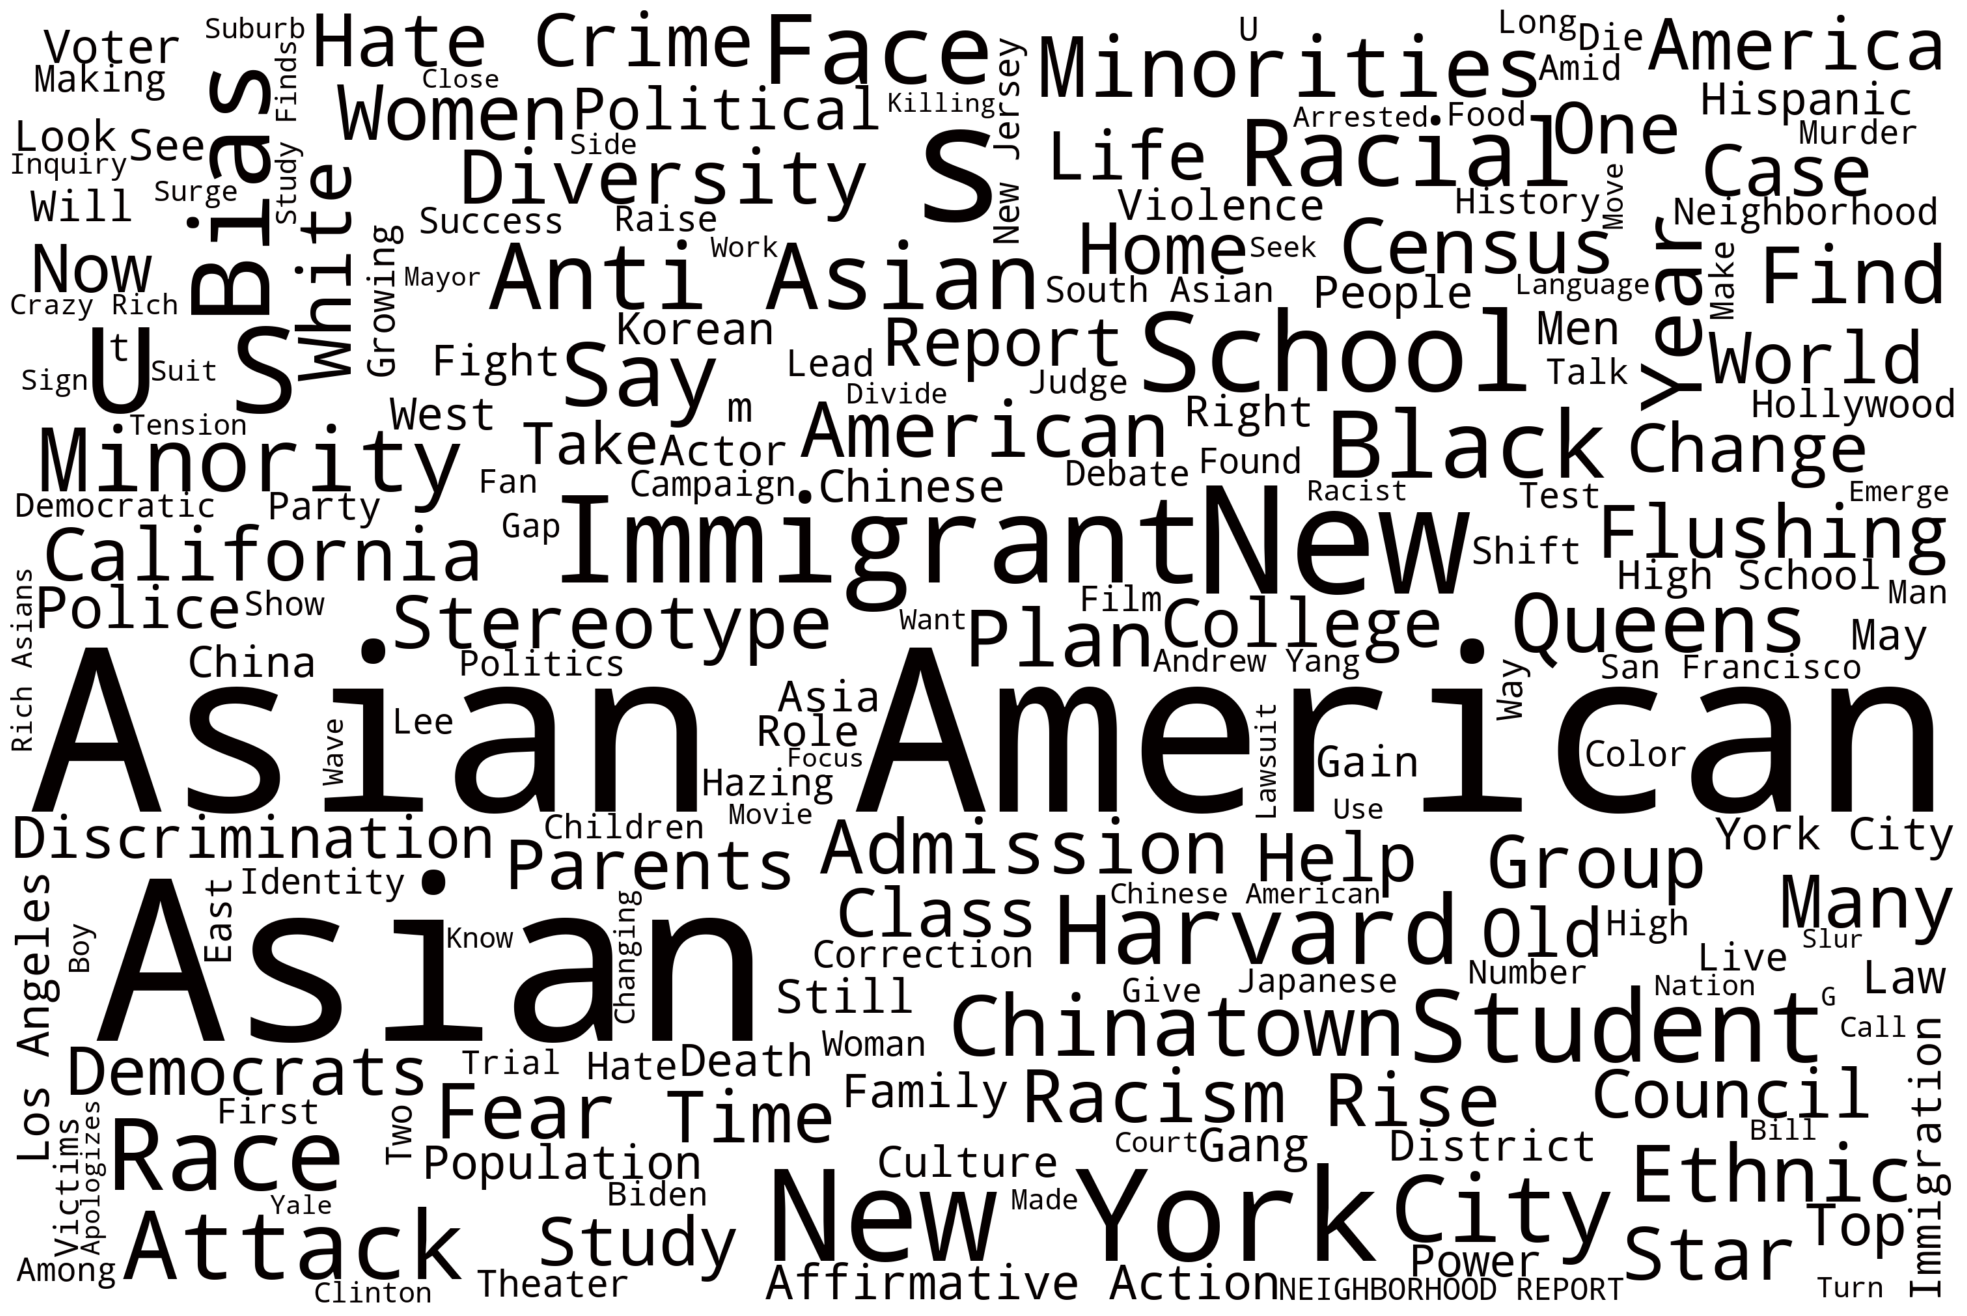

In [28]:
allData = pd.read_csv("Asians American NYT Dataset.csv")
all = " ".join(headline for headline in allData["headline"])
cloud = WordCloud(background_color="white", width=3000, height=2000).generate_from_text(all)
cloud.recolor(color_func=black_color_func)
plt.figure(figsize=[35, 30])
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('All Word Cloud.png')
plt.show()

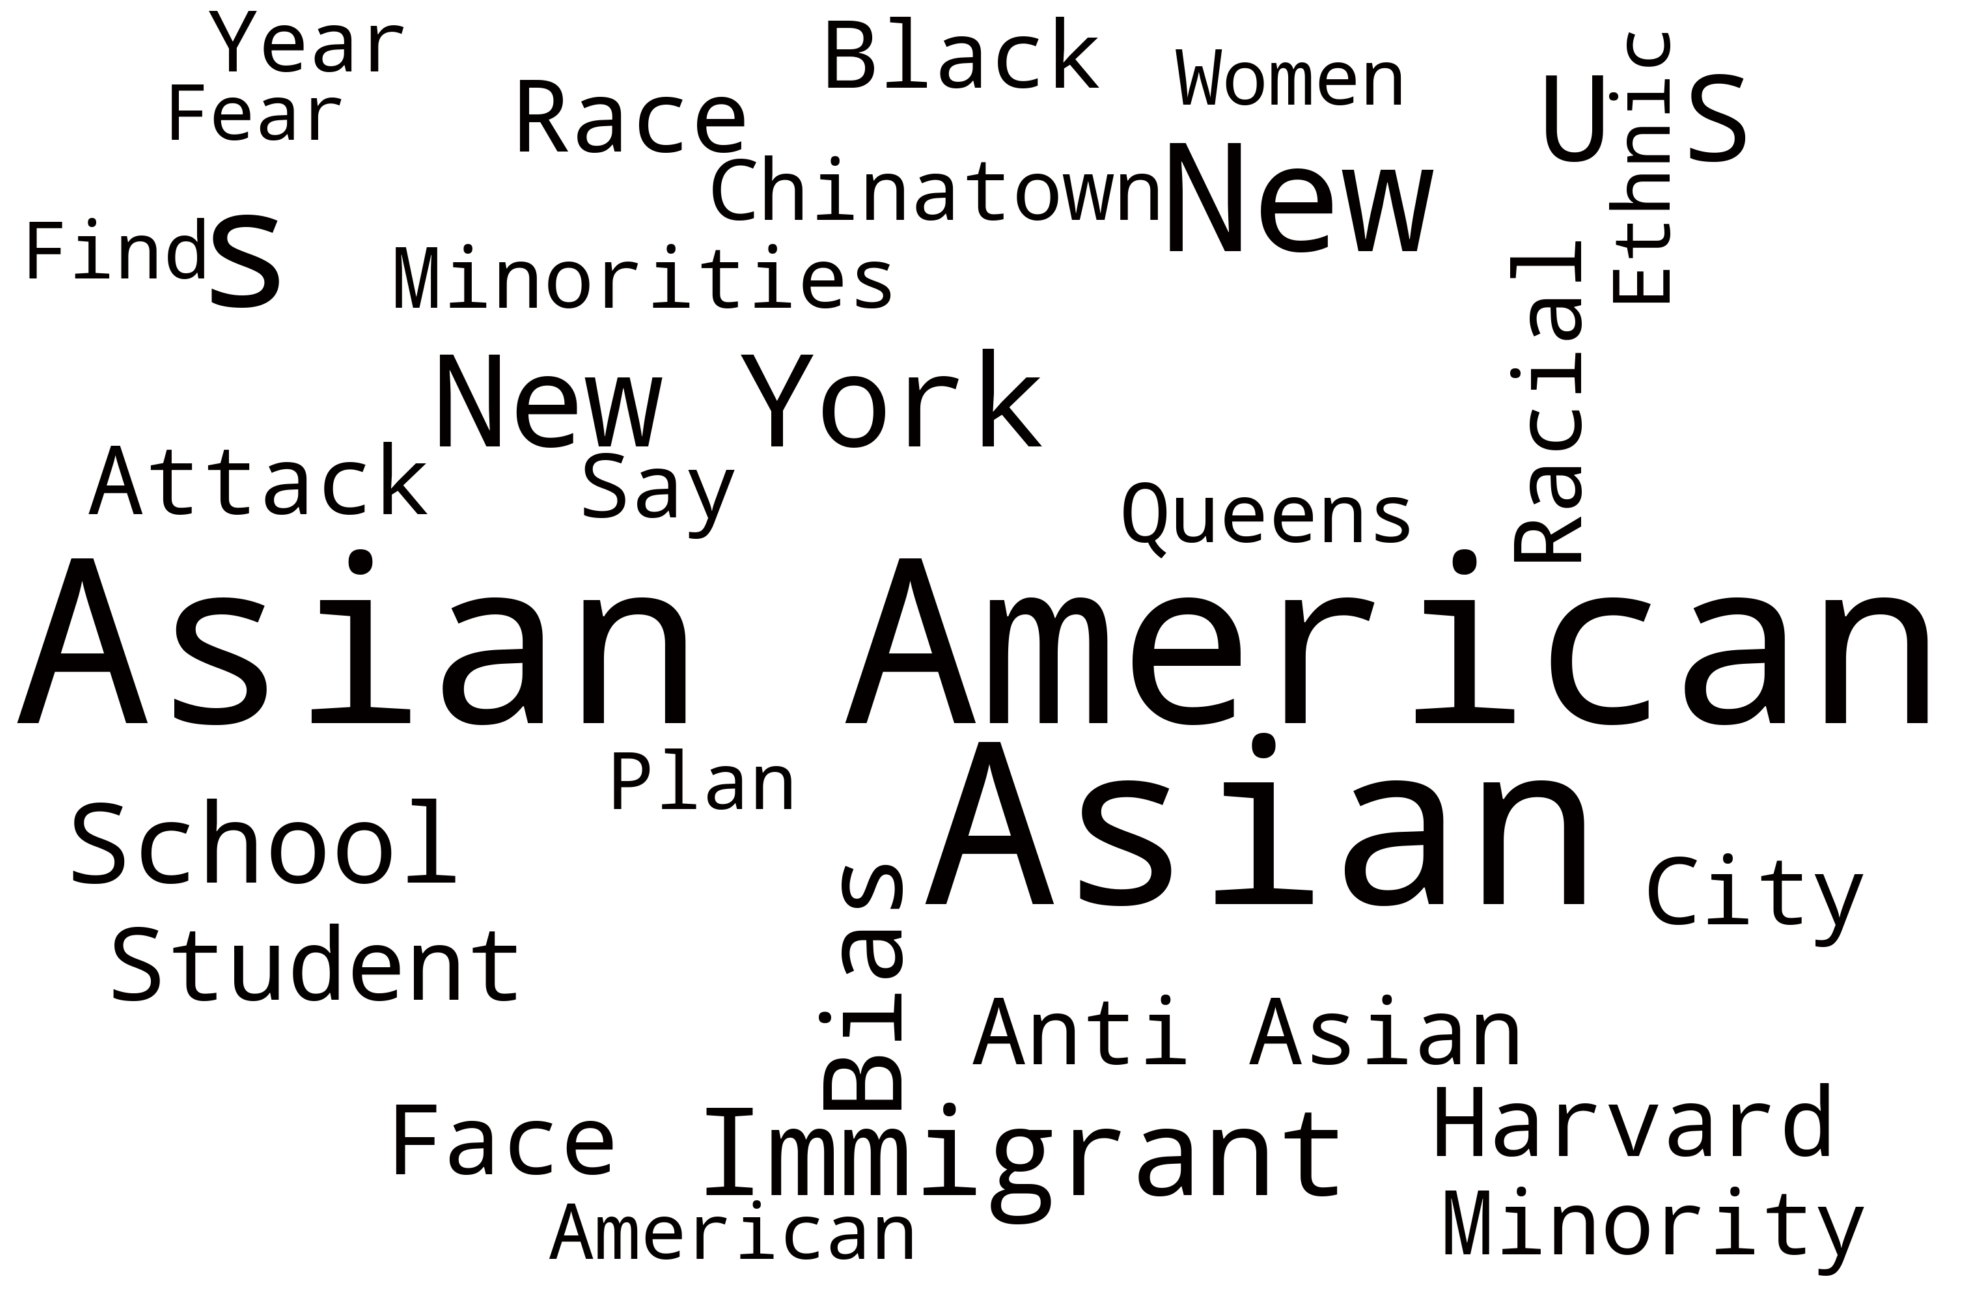

In [29]:
cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=30).generate_from_text(all)
cloud.recolor(color_func=black_color_func)
plt.figure(figsize=[35, 30])
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('All Limited Word Cloud.png')
plt.show()
